# Import Moduel

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import sqlite3
import pymongo
from wordcloud import WordCloud
# 設定中文字型為微軟正黑體
mpl.rcParams['font.family'] = 'Microsoft JhengHei' 

# Load Data

In [6]:
def get_sqlData(table_name, dbname = "Jobsearch_database.db"):
    conn = sqlite3.connect(dbname)
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df
def get_nosqlData(collection_name, dbname = "JobDB"):
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    db = client[dbname]
    collection = db[collection_name]
    cursor = collection.find({}, {'_id': 0})
    df = pd.DataFrame(list(cursor))
    return df

In [12]:
# SQL
df = get_sqlData('DE_jb')
print(df.shape)
# NoSQL
df = get_nosqlData('jobdata')
print(df.shape)

(2612, 23)
(2612, 23)


# EDA

In [13]:
ndf = df.copy()

## 縣市、工作經驗

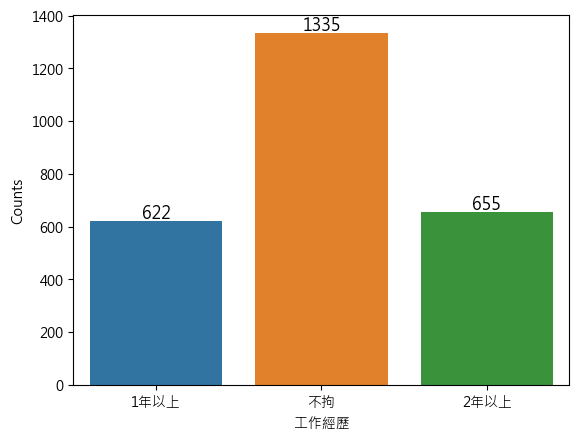

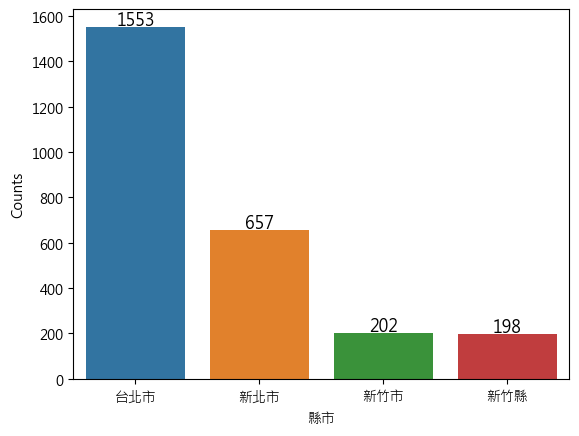

In [14]:
def count_plt(df, x):
    ax = sns.countplot(df, x=x)
    for p in ax.patches:
        h = int(p.get_height())
        ax.annotate(f'{h}', (p.get_x() + p.get_width() / 2., h),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.ylabel('Counts')
    plt.show()
count_plt(ndf, '工作經歷')
count_plt(ndf, '縣市')

## 常用工具

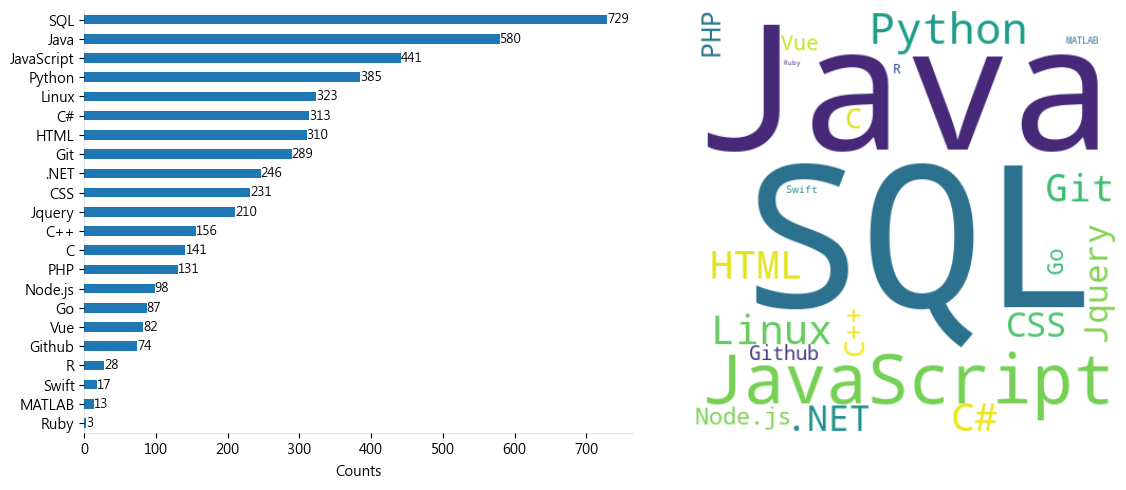

In [15]:
def tool_count(df):
    # 定義常見軟體業tool
    tool = {
        'Python': 0, 'C++': 0, 'Java': 0, 'JavaScript': 0, 'R':0,
        'C#': 0, 'C': 0, 'PHP': 0, 'Go': 0, '.NET': 0, 'HTML': 0,
        'SQL': 0, 'Swift': 0, 'MATLAB': 0, 'Ruby': 0, 'CSS': 0, 'Node.js': 0,
        'Linux': 0, 'Git': 0, 'Github': 0, 'Jquery':0, 'Vue': 0,
    }
    
    for k in tool.keys():
        if k == 'C++':
            tool[k] = df['擅長工具'].str.contains('C\+\+', case=False).sum()
        elif k == 'R':
            tool[k] = df['擅長工具'].apply(lambda x:bool(re.findall(r'R(?![A-Za-z])', x))).sum()
        elif k == 'C':
            tool[k] = df['擅長工具'].apply(lambda x:bool(re.findall(r'C(?![A-Za-z+#])', x))).sum()
        else:
            tool[k] = df['擅長工具'].str.contains(k, case=False).sum()
    tool_df = pd.DataFrame.from_dict(tool, orient='index', columns=['Count']).sort_values('Count')

    # plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    tool_df.plot(kind='barh', legend=None, ax=ax1)
    for i, v in enumerate(tool_df['Count']):
        ax1.text(v, i-0.2, str(v), fontsize=9)
    ax1.set_xlabel('Counts')
    
    spine_alpha = 0.1
    for spine in ax1.spines.values():
        spine.set_alpha(spine_alpha)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    # ax1.spines['bottom'].set_visible(False)
    # ax1.spines['left'].set_visible(False)

    # word cloud
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(tool)
    ax2.imshow(wordcloud, interpolation='bilinear')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return tool_df
tool_df = tool_count(df)

## 學歷要求

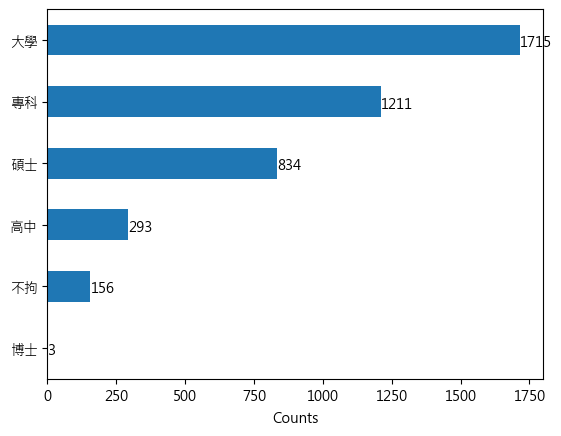

In [16]:
def Degree(df):
    # 定義學歷等級
    degree = {
        '不拘':0,
        '碩士':0,
        '大學':0,
        '博士':0,
        '高中':0,
        '專科':0
    }
    for k in degree.keys():
        degree[k] = df['學歷要求'].str.contains(k, case=False).sum()
    tool_df = pd.DataFrame.from_dict(degree, orient='index', columns=['Count']).sort_values('Count')
    ax = tool_df.plot(kind='barh', legend=None)
    for i, v in enumerate(tool_df['Count']):
        ax.text(v, i-0.1, str(v))
    plt.xlabel('Counts')
    plt.show()
Degree(ndf)

## 科系要求

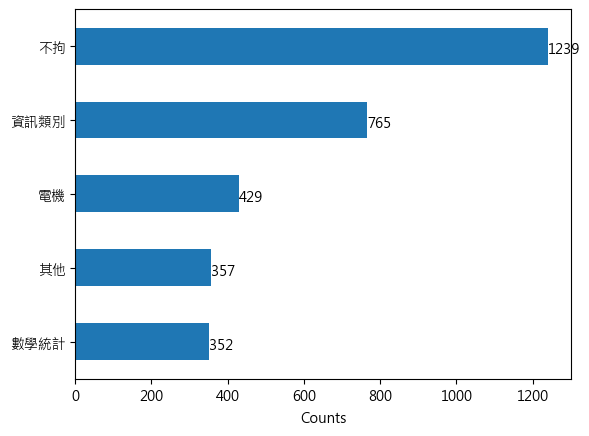

In [17]:
def Department(df):
    # 定義科系
    department = {
        '資訊類別':0,   # 資工、資管
        '電機':0,       # 電機、電子
        '數學統計':0,
        '不拘':0,
        '其他':0
    }
    for k in department.keys():
        if k == '資訊類別':
            department[k] = df['科系要求'].str.contains('資訊管理|資訊工程').sum()
        elif k == '電機':
            department[k] = df['科系要求'].str.contains('電機電子').sum()
        elif k == '數學統計':
            department[k] = df['科系要求'].str.contains('數學|統計').sum()
        elif k == '不拘':
            department[k] = sum(ndf['科系要求'] == '不拘')
        else:
            department['其他'] = df[~df['科系要求'].str.contains('資訊管理|資訊工程|電機電子|數學|統計|不拘')].shape[0]

    
    tool_df = pd.DataFrame.from_dict(department, orient='index', columns=['Count']).sort_values('Count')
    ax = tool_df.plot(kind='barh', legend=None)
    for i, v in enumerate(tool_df['Count']):
        ax.text(v, i-0.1, str(v))
    plt.xlabel('Counts')
    plt.show()
Department(ndf)